# 2D Fourier transforms for image processing in Retinal Implants

In [31]:
import torch
import torch.fft
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder


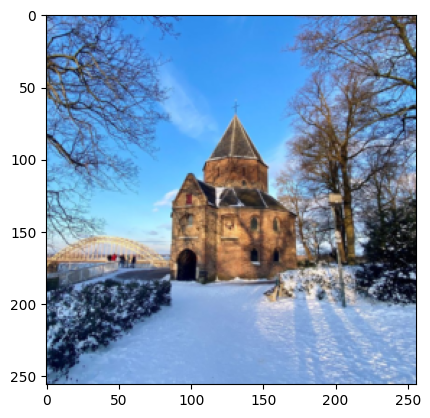

Image shape: torch.Size([1, 1, 256, 256])


In [72]:
transform = transforms.Compose([
    # crop to square
    transforms.CenterCrop(800),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_set = ImageFolder('../example_images/', transform=transform)

index = 5
img_color = data_set.__getitem__(index)[0].unsqueeze(0)

# grayscale
img = img_color.mean(dim=1, keepdim=True)
img = img.cuda().detach()

plt.imshow(img_color[0].permute(1, 2, 0))
plt.show()
print("Image shape:", img.shape)

In [73]:
fft_img = torch.fft.fft2(img)

# fft_img is complex64 or complex128
magnitude = torch.abs(fft_img)  # amplitude
phase = torch.angle(fft_img)    # phase in radians

fft_img_shifted = torch.fft.fftshift(fft_img) # shift zero frequency component to center
magnitude_shifted = torch.abs(fft_img_shifted) # amplitude
phase_shifted = torch.angle(fft_img_shifted)   # phase in radians

magnitude_log = torch.log1p(magnitude_shifted) # log(1 + amplitude)

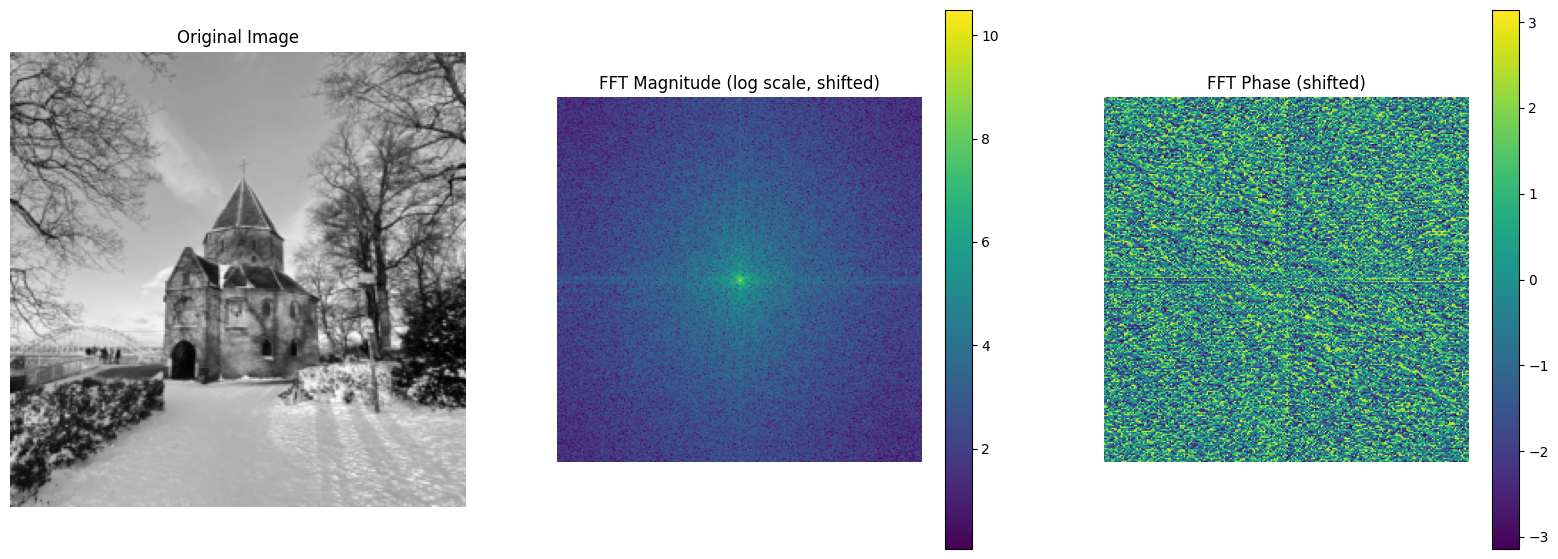

In [78]:
# Original image
original_img = img[0, 0].cpu()

# Shifted magnitude & phase
mag_for_viz = magnitude_log[0, 0].cpu()
phase_for_viz = phase_shifted[0, 0].cpu()

fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs[0].imshow(original_img, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(mag_for_viz)
axs[1].set_title('FFT Magnitude (log scale, shifted)')
# colorbar
plt.colorbar(axs[1].imshow(mag_for_viz), ax=axs[1])
axs[1].axis('off')

axs[2].imshow(phase_for_viz)
axs[2].set_title('FFT Phase (shifted)')
# colorbar
plt.colorbar(axs[2].imshow(phase_for_viz), ax=axs[2])
axs[2].axis('off')

plt.show()

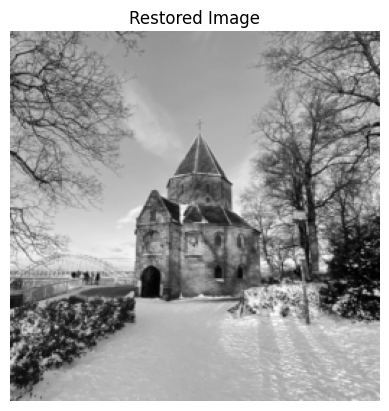

In [79]:
# Inverse FFT
fft_img_restored = torch.fft.ifftshift(fft_img_shifted)
img_restored = torch.fft.ifft2(fft_img_restored)
img_restored = torch.abs(img_restored)

plt.imshow(img_restored[0, 0].cpu(), cmap='gray')
plt.title('Restored Image')
plt.axis('off')
plt.show()

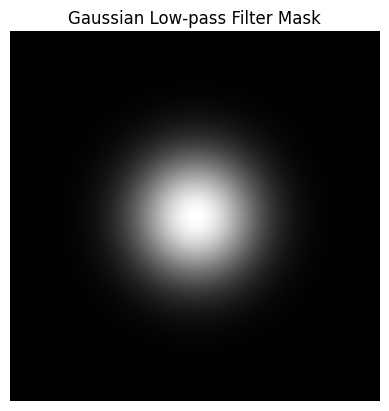

In [97]:
def frequency_filter_2d(img_tensor: torch.Tensor, mask_tensor: torch.Tensor):
    """
    Apply a frequency-domain filter (mask_tensor) to img_tensor.
    img_tensor shape: (B, C, H, W)
    mask_tensor shape: (H, W) or (1, 1, H, W) broadcastable to (B, C, H, W)
    """
    # 1) Forward FFT: shape stays (B, C, H, W)
    # torch.fft.fft2 does a 2D FFT over the last two dimensions
    fft_img = torch.fft.fft2(img_tensor)
    
    # 2) Shift the zero-frequency component to the center
    fft_img_shifted = torch.fft.fftshift(fft_img, dim=(-2, -1))
    
    # 3) Multiply by the mask (must be broadcastable to the same shape as fft_img_shifted)
    filtered_shifted = fft_img_shifted * mask_tensor
    
    # 4) Inverse shift
    filtered_unshifted = torch.fft.ifftshift(filtered_shifted, dim=(-2, -1))
    
    # 5) Inverse FFT
    filtered_spatial = torch.fft.ifft2(filtered_unshifted)
    
    # Return real magnitude (or just .real if you want the real part)
    return torch.abs(filtered_spatial)

def build_gaussian_lowpass_mask(H, W, sigma=30.0, device='cpu'):
    """
    Build a 2D Gaussian low-pass filter mask in frequency domain.
    sigma defines how quickly the mask falls off.
    """
    # Create a grid of frequencies
    # We'll index from -(H//2) to +(H//2 - 1) for rows, etc.
    # or we can just create a [0..H-1] range and shift center later.
    y = torch.linspace(-H//2, H//2 - 1, H)
    x = torch.linspace(-W//2, W//2 - 1, W)
    yy, xx = torch.meshgrid(y, x, indexing='ij')
    
    # Distance squared from center
    dist_sq = xx**2 + yy**2
    
    # Gaussian in frequency domain
    # If you imagine a standard low-pass, it looks like exp(-dist_sq/(2*sigma^2)).
    mask = torch.exp(-dist_sq / (2 * sigma**2))
    
    return mask.to(device)



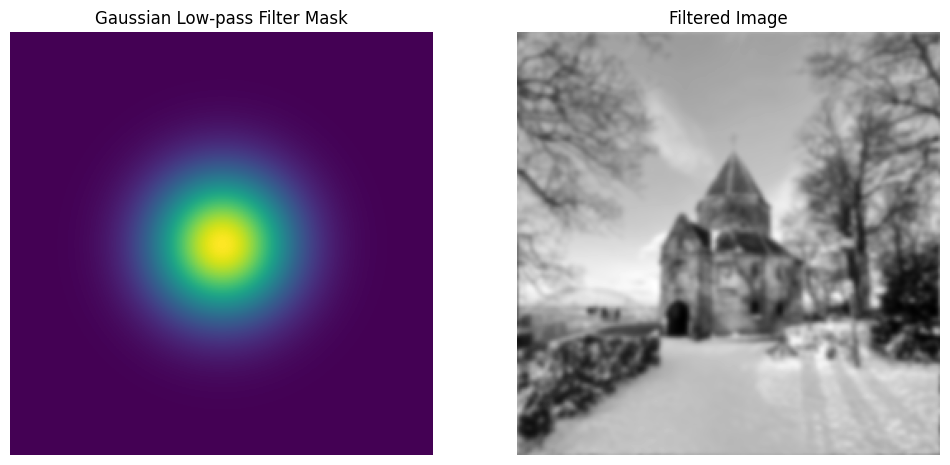

In [107]:
# Create a Gaussian low-pass filter mask
mask = build_gaussian_lowpass_mask(256, 256, sigma=30.0, device='cuda')

# Apply the filter
filtered_img = frequency_filter_2d(img, mask)

# show the mask and the filtered image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mask.cpu())
plt.title('Gaussian Low-pass Filter Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_img[0, 0].cpu(), cmap='gray')
plt.title('Filtered Image')
plt.axis('off')
plt.show()

In [136]:
import torch
import torch.fft

def build_log_kernel_2d(H, W, sigma=3.0):
    """
    Build a 2D Laplacian-of-Gaussian kernel in spatial domain.
    Returns a tensor shape (H, W).
    """
    # Coordinate grids: center them so (0,0) is roughly in the middle
    # We'll assume H, W are even for simplicity
    y = torch.arange(-H//2, H//2, dtype=torch.float32)
    x = torch.arange(-W//2, W//2, dtype=torch.float32)
    Y, X = torch.meshgrid(y, x, indexing='ij')
    
    # r^2 = x^2 + y^2
    R2 = X**2 + Y**2
    
    # LoG formula (one common form)
    # Feel free to tweak constants. This version integrates to ~0.
    # It's typical to omit the 1/(pi*sigma^4) factor if you just want
    # the shape rather than strict normalization.
    norm = -1.0 / (3.14159 * sigma**4)
    LoG = norm * (1.0 - R2 / (2.0 * sigma**2)) * torch.exp(-R2 / (2.0 * sigma**2))
    
    # Optional: zero-mean normalization or other scaling
    # Because the integral of LoG is ~0, the sum might be near 0, but we can check:
    # LoG = LoG - LoG.mean()
    
    return LoG


def build_log_filter_frequency(H, W, sigma=3.0, device='cuda'):
    """
    Build the frequency-domain representation (FFT) of a LoG kernel of size H x W.
    """
    log_kernel = build_log_kernel_2d(H, W, sigma)
    log_kernel = log_kernel.to(device)
    
    # Convert to (1,1,H,W) so we can do fft2 in PyTorch
    log_kernel_4d = log_kernel.unsqueeze(0).unsqueeze(0)
    
    # FFT of kernel
    fft_log_kernel = torch.fft.fft2(log_kernel_4d)
    # We don't necessarily need to fftshift here if we'll treat it
    # consistently. The shift is mostly for visualization.
    
    return fft_log_kernel

def frequency_filter_2d(img_4d: torch.Tensor, filter_4d: torch.Tensor):
    """
    Multiply the FFT of img_4d by filter_4d in frequency domain and iFFT back.
    img_4d, filter_4d shape: (B, C, H, W)
    """
    fft_img = torch.fft.fft2(img_4d)
    # elementwise multiplication in the frequency domain
    fft_filtered = fft_img * filter_4d
    
    # inverse FFT to get back to spatial domain
    filtered_spatial = torch.fft.ifft2(fft_filtered)
    
    # typically take the real part (in practice, your image is real)
    filtered_spatial = torch.real(filtered_spatial)
    return filtered_spatial


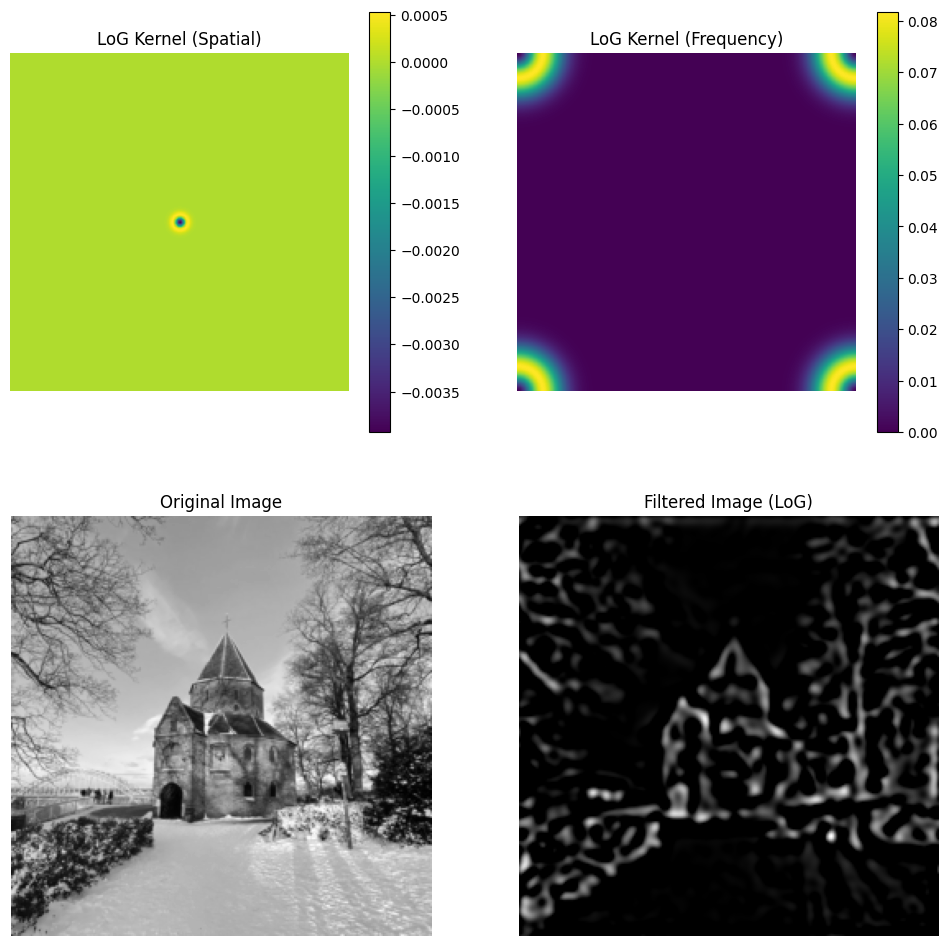

In [151]:
# 1) Build LoG filter (in frequency) for the same size H x W
H, W = img.shape[-2:]

sigma = 3
fft_log_kernel = build_log_filter_frequency(H, W, sigma=sigma, device=img.device)
# shift for visualization
fft_log_kernel_shifted = torch.fft.fftshift(fft_log_kernel, dim=(-2, -1))

# 2) Filter the image in frequency domain
filtered_img_log = frequency_filter_2d(img, fft_log_kernel)
# shift
filtered_img_log = torch.fft.ifftshift(filtered_img_log, dim=(-2, -1))

# 3) Visualize results: show input image, LoG kernel in the spatial and in the frequency domain, and filtered image
# LoG kernel in spatial domain
log_kernel = build_log_kernel_2d(H, W, sigma=sigma)
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(log_kernel.cpu())
plt.title('LoG Kernel (Spatial)')
# colorbar
plt.colorbar(plt.imshow(log_kernel.cpu()))
plt.axis('off')

# LoG kernel in frequency domain
log_kernel_freq = torch.abs(fft_log_kernel[0, 0].cpu())
fft_log_kernel_shifted = torch.abs(fft_log_kernel_shifted[0, 0].cpu())
plt.subplot(2, 2, 2)
plt.imshow(log_kernel_freq)
plt.title('LoG Kernel (Frequency)')
# colorbar
plt.colorbar(plt.imshow(log_kernel_freq))
plt.axis('off')

# Original image
plt.subplot(2, 2, 3)
plt.imshow(img[0, 0].cpu(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Filtered image
plt.subplot(2, 2, 4)
plt.imshow(filtered_img_log[0, 0].cpu().clip(0, None), cmap='gray')
plt.title('Filtered Image (LoG)')
plt.axis('off')

plt.show()